# Basics of Kinematic Modeling

In this notebook, we will introduce the fundamentals of creating a kinematic model using the [Robotics Toolbox for Python](https://github.com/petercorke/robotics-toolbox-python). 

We will first demonstrate these concepts on a **hypothetical 2-link robot arm** using the **Standard Denavit-Hartenberg (DH)** convention. Afterward, your task will be to apply these principles to build the kinematic model for the **UR3e**.

## 1. Understanding DH Parameters

The Denavit-Hartenberg (DH) convention allows us to describe the geometry of a robot arm by defining four parameters for each link. Since the joint angle ($\theta$) is usually the variable that changes as the robot moves, we define the robot's physical structure using the remaining three constant parameters. The DH parameters can be a bit tricky to grasp a first, and it's not necessary to have a deep understanding of them to use the Robotics Toolbox effectively. However, having a basic idea can be very helpful.

### The Three Constants

1. **`d` (Link Offset)**:  
   *Ideally, how "tall" or "deep" is the connection along the joint axis?* 
   This is the distance measured along the joint's rotation axis (Z-axis). For a vertical joint, this is often the height of the link.

2. **`a` (Link Length)**:  
   *How long is the arm segment?* 
   This is the shortest distance between the current joint axis and the next one. It is measured along the common normal (X-axis).

3. **`alpha` (Link Twist)**:  
   *Does the next joint rotate in a different orientation?* 
   This is the angle between the current joint axis and the next one. For example, if one joint rotates horizontally and the next vertically, the twist is likely 90 degrees ($\pi/2$ radians).

See also [this youtube video](https://www.youtube.com/watch?v=rA9tm0gTln8) for a visual explanation of DH parameters.

We start by importing the necessary libraries. The magic command `%matplotlib ipympl` enables interactive plots within Jupyter notebooks.


In [3]:

import roboticstoolbox as rtb
import spatialmath as sm
import numpy as np

## 2. Tutorial: A Simple 2-Link Robot

Let's model a simple hypothetical robot with 2 rotational joints using **Standard DH** parameters (`RevoluteDH`).

### Defining the Robot
We will define a robot where:
- **Link 1**: Has a length of 0.5m (`a=0.5`).
- **Link 2**: Has a length of 0.3m (`a=0.3`).
- **Tool**: Attached to the end of Link 2.

In [4]:
# Define Link 1
# d=0 (no vertical offset), a=0.5 (length), alpha=0 (axes are parallel)
link1 = rtb.RevoluteDH(d=0.0, a=0.5, alpha=0.0)

# Define Link 2
# d=0, a=0.3 (length), alpha=0
link2 = rtb.RevoluteDH(d=0.0, a=0.3, alpha=0.0)

# Create the Robot Object
simple_robot = rtb.DHRobot([link1, link2], name="Simple_2Link")

print(simple_robot)

DHRobot: Simple_2Link, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.5 │ 0.0° │
│  q2 │  0 │ 0.3 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘



### Visualization
We can visualize the robot in a specific joint configuration `q` (in radians).

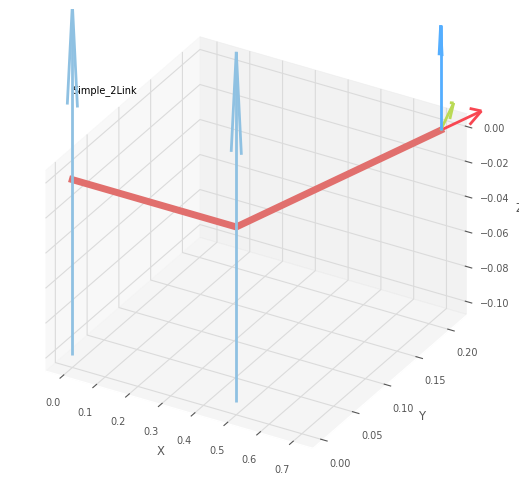

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Simple_2Link')

<Figure size 640x480 with 0 Axes>

In [5]:
# Define a configuration: Joint 1 at 0 rad, Joint 2 at 45 degrees (pi/4)
q_test = np.array([0, np.pi/4])

# Plot using the pyplot backend
simple_robot.plot(q_test, backend='pyplot')

### Forward Kinematics (FK)
Forward Kinematics answers the question: *"Given these joint angles, where is the robot's end-effector?"*

We use the `.fkine(q)` method, which returns an **SE(3)** (Special Euclidean group in 3D) object representing the pose.

In [6]:
# Calculate FK for the test configuration
T_current = simple_robot.fkine(q_test)

print("Joint Config (rad):", q_test)
print("\nEnd-Effector Pose (Transformation Matrix):")
print(T_current)

Joint Config (rad): [0.         0.78539816]

End-Effector Pose (Transformation Matrix):
   0.7071   -0.7071    0         0.7121    
   0.7071    0.7071    0         0.2121    
   0         0         1         0         
   0         0         0         1         



#### Understanding the FK Output

The output you see above is a **4x4 Homogeneous Transformation Matrix**.

```text
   [ r11   r12   r13   tx ]
   [ r21   r22   r23   ty ]
   [ r31   r32   r33   tz ]
   [  0     0     0     1 ]
```

* **Top-Left 3x3 (`r` values)**: Represents the **Rotation** (orientation) of the tool frame relative to the base.
* **Right Column (`tx, ty, tz`)**: Represents the **Translation** (position X, Y, Z) of the tool frame relative to the base.

While matrices are great for math, they are hard for humans to read. We often convert this to **XYZ (Position)** and **RPY (Roll-Pitch-Yaw / Orientation)** for easier inspection.

In [7]:
# Convert to human-readable format
# .t property gives [x, y, z]
# .rpy() method gives [roll, pitch, yaw] in radians

tcp_rpy = T_current.rpy(order='xyz')
tcp_xyz = T_current.t
tcp = np.hstack((tcp_xyz, tcp_rpy))

print("\nEnd-Effector Pose (XYZ + RPY):")
print(tcp)


End-Effector Pose (XYZ + RPY):
[ 0.71213203  0.21213203  0.          0.78539816  0.         -0.        ]


### Inverse Kinematics (IK)
Inverse Kinematics answers the question: *"I want the robot hand to be HERE. What joint angles do I need?"*

We use the `.ikine_LM(T)` method (Levenberg-Marquardt numerical solver).

In [8]:
# Let's define a target pose. 
# For simplicity, we use the pose we just calculated above (T_current).
target_pose = T_current

# Solve IK
sol = simple_robot.ikine_LM(target_pose)

print("Target Pose:\n", target_pose.t) 
print("\nFound Joint Solution:", sol.q)
print("Success:", sol.success)

# Verify by plugging the solution back into FK
T_check = simple_robot.fkine(sol.q)
print("\nCheck Pose:\n", T_check.t)

Target Pose:
 [0.71213203 0.21213203 0.        ]

Found Joint Solution: [-5.81233950e-08  7.85398351e-01]
Success: True

Check Pose:
 [0.71213201 0.21213203 0.        ]


#### Understanding the IK Output

The solver returns an object with several useful fields:

* **`Found Joint Solution` (sol.q)**: This is the calculated array of joint angles (radians) that the robot should move to.
* **`Success` (sol.success)**: A boolean flag. `True` means the solver found a valid configuration close enough to the target. `False` means it failed (e.g., the target is out of reach or the solver got stuck).
* **`Check Pose`**: It is always good practice to verify the result by plugging the solution `q` back into `.fkine()` to ensure the resulting position matches your target.

### Trajectory Generation

Robots rarely jump instantly from one pose to another. Instead, we compute a smooth **Trajectory** that gradually changes the joint angles over time.

We can use `rtb.jtraj` (Joint-space Trajectory) to generate a path between a start configuration (`q_start`) and an end configuration (`q_end`) over a number of steps. See also [the documentation](https://petercorke.github.io/robotics-toolbox-python/arm_trajectory.html#) for more details.

Shape of trajectory: (50, 2)


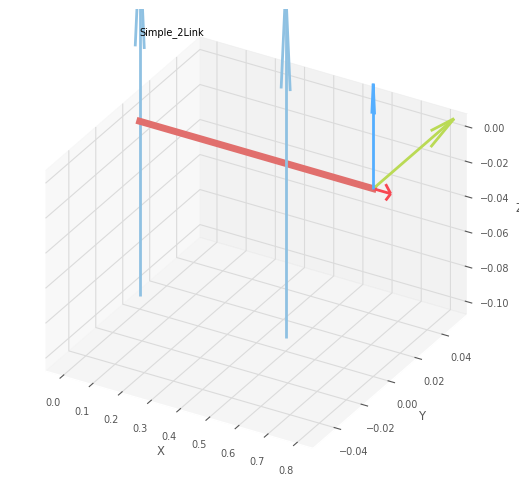

PyPlot3D backend, t = 2.499999999999999, scene:
  robot: Text(0.0, 0.0, 'Simple_2Link')

<Figure size 640x480 with 0 Axes>

In [9]:
# 1. Define Start and End joint configurations
q_start = np.array([0, 0])           # Robot straight out
q_end   = np.array([np.pi/2, np.pi/2]) # Robot folded 90 degrees

# 2. Generate trajectory (50 steps)
traj = rtb.jtraj(q_start, q_end, 50)

# traj.q contains the 50x2 array of joint angles for the path
print("Shape of trajectory:", traj.q.shape)

# 3. Visualize the movement
# This will animate the robot moving through the path
simple_robot.plot(traj.q, backend='pyplot')

In [10]:
# show attributes of traj
print("Trajectory q shape:", traj.q.shape)
print("First configuration in trajectory:", traj.q[0])
print("Last configuration in trajectory:", traj.q[-1]) 
print("Time steps (1-5):", traj.t[:5])

Trajectory q shape: (50, 2)
First configuration in trajectory: [0. 0.]
Last configuration in trajectory: [1.57079633 1.57079633]
Time steps (1-5): [0.         1.02040816 2.04081633 3.06122449 4.08163265]


Above, we specified that the movement should occur over 50 steps. This means the trajectory will consist of 50 intermediate joint configurations that smoothly transition from `q_start` to `q_end`. Each time step has a duration of 0.05 seconds, resulting in a total movement time of 2.5 seconds (50 steps * 0.05 seconds/step). If you rather want to specify the total time for the movement, you can compute the number of steps needed based on your desired total time and time step duration:
$$
\text{Number of Steps} = \left\lfloor\frac{\text{Total Time}}{\text{Time Step Duration}}\right\rfloor
$$
For instance, to achieve the 2.5 seconds total time with a 0.05 seconds time step, you would calculate:
$$
\text{Number of Steps} = \left\lfloor\frac{2.5 \text{ seconds}}{0.05 \text{ seconds/step}}\right\rfloor = 50 \text{ steps}
$$
Corresponding to the example above.

**Task: How would you estimate the total movement time if you know the acceleration and maximum velocity constraints of the joints?**

## 3. Your Task: The UR3e Model

Now that you understand the basics, you must build the object for the **UR3e** robot.

You can find the official DH parameters for the UR3e on the Universal Robots support site:

> **[UR Support: DH parameters for calculations of kinematics and dynamics](https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/)**

**Pointers:**
1. **Use Standard DH**: Use `RevoluteDH` for all joints.

In [11]:
# TODO: Fill in the correct parameters from the UR website

link1 = rtb.RevoluteDH(d=0.15185, a=0.0, alpha=np.pi/2)
link2 = rtb.RevoluteDH(d=0.0, a=-0.24355, alpha=0.0)
link3 = rtb.RevoluteDH(d=0.0, a=-0.2132, alpha=0.0)
link4 = rtb.RevoluteDH(d=0.13105, a=0.0, alpha=np.pi/2)
link5 = rtb.RevoluteDH(d=0.08535, a=0.0, alpha=-np.pi/2)
link6 = rtb.RevoluteDH(d=0.0921, a=0.0, alpha=0.0)
# Create the robot object
my_ur3e = rtb.DHRobot([link1, link2, link3, link4, link5, link6], name="My_UR3e")

print(my_ur3e)

DHRobot: My_UR3e, 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬─────────┬─────────┬────────┐
│ θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │
├─────┼─────────┼─────────┼────────┤
│  q1 │  0.1519 │       0 │  90.0° │
│  q2 │       0 │ -0.2435 │   0.0° │
│  q3 │       0 │ -0.2132 │   0.0° │
│  q4 │   0.131 │       0 │  90.0° │
│  q5 │ 0.08535 │       0 │ -90.0° │
│  q6 │  0.0921 │       0 │   0.0° │
└─────┴─────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘



### Sanity Check
To see if the model is correct, we can try placing the robot in an upright position and visualize it. The end-effector should be directly above the base. An upright position for the UR3e corresponds to the position:
$$
[0, -\pi/2, 0, -\pi/2, 0, 0]
$$
Here, we set the joint angles such that the second joint is at 90 degrees ($\pi/2$ radians) and the fourth joint is at -90 degrees ($-\pi/2$ radians), while all other joints are at 0 radians. This configuration should position the end-effector directly above the base of the robot.

Try computing the FK for this configuration and obtain the vector $[x, y, z]$ representing the position of the end-effector. Since the robot is upright, you should expect the $x$ position to be close to 0, the $y$ position to be the *width* of the robot arm, and the $z$ position to be the *height* of the end-effector above the base. Note that the signs may vary based on the coordinate system used.



In this specific upright configuration, the robot is essentially folded into a vertical structure that steps "out" sideways at the wrist.

Based on the UR3e geometry and this specific pose, the coordinates are calculated by summing specific geometric lengths:

**Height:**

$$Z = d_1 + |a_2| + |a_3| + d_5$$

**Width:**
$$Y = d_4 + d_6$$

To understand why these specific parameters sum up this way, we have to trace the robot link-by-link. In the DH convention, $d$ is the distance along the joint axis, and $a$ is the length of the link itself.

### Calculating Height (Z)

The robot reaches its height because four specific vertical segments are stacked on top of each other:

1. $d_1$ (Shoulder Offset): This is the fixed vertical distance from the base to the center of the shoulder joint.
   - Contribution: Up (+Z)

2. $|a_2|$ (Upper Arm): Normally, the Upper Arm extends horizontally. However, the joint angle $\theta_2 = -\pi/2$ points the arm straight up.
   - Contribution: Up (+Z)

3. $|a_3|$ (Forearm): Since the elbow angle $\theta_3 = 0$, the forearm continues in a straight line from the upper arm, extending further upwards.
   - Contribution: Up (+Z)

4. $d_5$ (Wrist 2 Length): This is the tricky one.
   - Normally, $d$ offsets move "sideways" along joint axes.

   - However, your Wrist 1 joint ($\theta_4$) is rotated to $-\pi/2$. This $90^\circ$ bend turns the rest of the wrist mechanism upwards.

   - Because of this bend, the length of Wrist 2 ($d_5$) now points vertically instead of horizontally.

   - Contribution: Up (+Z)

### Calculating Width (Y)

The robot has a "depth" or "width" because two wrist segments extend sideways along the Y-axis:

1. $d_4$ (Wrist 1 Length):
   - The axis of rotation for the Shoulder Lift, Elbow, and Wrist 1 are all parallel.

   - Because $\theta_1 = 0$ (Base), these axes align with the World Y-axis.

   - The parameter $d_4$ represents the distance along this axis (the length of the Wrist 1 housing).

   - Contribution: Sideways (+Y)

2. $d_6$ (Wrist 3 / Flange Length):
   - After the upward bend caused by Wrist 1 ($d_5$ pointing up), the wrist geometry (specifically the $\alpha$ parameters) turns the axis for the final joint back to horizontal.
Therefore, the final distance to the TCP ($d_6$) extends sideways, parallel to $d_4$.

   - Contribution: Sideways (+Y)

### Summary of the Pose

- Base: Fixed.
- Shoulder & Arm: Point straight up ($d_1 + a_2 + a_3$).
- Wrist 1: Pushes out sideways ($d_4$).
- Wrist 2: Pushes up again ($d_5$) due to the 90-degree wrist bend.
- Wrist 3: Pushes out sideways again ($d_6$).

In [ ]:
q_straigt = np.array([0, -np.pi/2, 0, -np.pi/2, 0, 0])

# TODO: Try computing the FK for this configuration.
# TODO: Try to plot the robot in this configuration as well and confirm its upright pose.